In [1]:
from qiime2 import Visualization, Artifact, Metadata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from skbio.stats import composition
%matplotlib inline

In [2]:
%cd "/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101/reanalysis-2/"

/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101/reanalysis-2


In [3]:
ls

ANCOM-L2-chemo.qzv           expr-group-metadata.tsv
ANCOM-L6-chemo.qzv           filt-seq-taxa-barplot.qzv
Figures/                     insertion-tree.qza
L2-nobloom-pseudo-table.qza  nobloom_metadata.tsv
L2-nobloom-table.qza         nobloom_table.qza
L6-nobloom-pseudo-table.qza  nobloom_table.qzv
L6-nobloom-table.qza         samp-filt-seq-table.qza
core-diversity-results/      taxonomy-gg.qza
diversity-stats-results/


# Create Input Data

## Load in feature table, make sure index lines up

In [4]:
tax_df = Artifact.load("L6-nobloom-table.qza")
tax_df = tax_df.view(pd.DataFrame)
tax_df.columns = ["|".join(x.split(";")) for x in tax_df.columns]

In [5]:
for row in tax_df.index:
    tax_df.loc[row] = tax_df.loc[row].apply(lambda x: x/sum(tax_df.loc[row]))

In [6]:
tax_df.head()

,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter,k__Archaea|p__Euryarchaeota|c__Thermoplasmata|o__E2|f__[Methanomassiliicoccaceae]|g__vadinCA11,k__Bacteria|__|__|__|__|__,k__Bacteria|p__|c__|o__|f__|g__,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Arcanobacterium,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Mobiluncus,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Varibaculum,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Brevibacteriaceae|g__Brevibacterium,...,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Actinobacillus,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Stenotrophomonas,k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Dethiosulfovibrionaceae|g__Jonquetella,k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Cloacibacillus,k__Bacteria|p__Tenericutes|c__Mollicutes|o__RF39|f__|g__,k__Bacteria|p__Tenericutes|c__RF3|o__ML615J-28|f__|g__,k__Bacteria|p__Verrucomicrobia|c__Opitutae|o__[Cerasicoccales]|f__[Cerasicoccaceae]|g__,k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Verrucomicrobiaceae|g__Akkermansia
1,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
10,0.000000,0.005397,0.0,0.000048,0.0,0.003566,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.010553,0.000000,0.0,0.000000
12,0.000000,0.000000,0.0,0.000061,0.0,0.000000,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
14,0.000126,0.000000,0.0,0.000189,0.0,0.001451,0.0,0.0,0.00041,0.0,...,0.002428,0.0,0.0,0.0,0.0,0.000000,0.007552,0.000000,0.0,0.000000
15,0.000000,0.002964,0.0,0.000800,0.0,0.000341,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000302,0.003738,0.003095,0.0,0.002452


In [7]:
mapping = pd.read_csv("nobloom_metadata.tsv", sep="\t",
                     index_col="sampleid")
mapping

,barcodesequence,linkerprimersequence,study,plate.sample.id,plate.well.id,primer.plate,primer.well.id,body-site,date_collected,time_collected,...,fact_c_qol_2-cat,fact_c_qol_3-cat,fact_c_qol_4-cat,Zpromis_Tscore_TOTAL,Zstress_scale_TOTAL,Zcesd_TOTAL,Zdistress_total,StudyID,Time difference,Experimental Group
sampleid,,,,,,,,,,,,,,,,,,,,,
1,TAGACCGACTCC,AA,CU Denver BC Microbiome,1001-S1,A1,7.0,A1,gut,10/2/18,Not listed,...,Not at all,Not at all,Not at all,1.47103,-0.01736,0.73560,2.19,1001,42.0,Group 1
3,TCCGACCCGATC,AA,CU Denver BC Microbiome,1005,C1,7.0,C1,gut,5/4/19,7:20 AM,...,Not at all,Not at all,Not at all,0.49597,0.79283,0.36780,1.66,1005,NaN,Group 2
4,TCACTGCTAGGA,AA,CU Denver BC Microbiome,1006-S1,D1,7.0,D1,gut,2/23/18,6:35 AM,...,Not at all,Not at all,Not at all,-0.65763,-0.62501,-1.22601,-2.51,1006,NaN,Group 2
6,AGCTATGTATGG,AA,CU Denver BC Microbiome,1007 - S1,F1,7.0,F1,gut,11/14/18,Not listed,...,Not at all,Not at all,Not at all,0.27623,1.19793,1.96161,3.44,1007,NaN,Group 2
8,AAGGGTTAGTCT,AA,CU Denver BC Microbiome,1008-S1,H1,7.0,H1,gut,4/13/18,Not listed,...,Not at all,Not at all,Not at all,-0.32803,-0.42246,0.00000,-0.75,1008,NaN,Group 2
10,TTCCCACCCATT,AA,CU Denver BC Microbiome,1009 - S1,B2,7.0,B2,gut,2/10/19,Not listed,...,Not at all,Not at all,Not at all,-0.10830,-1.23265,-0.98081,-2.32,1009,NaN,Group 2
12,GGTCCTTCCCGA,AA,CU Denver BC Microbiome,1010-S1,D2,7.0,D2,gut,12/14/18,Not listed,...,Somewhat,A little bit,A little bit,0.27623,-0.42246,-0.85821,-1.00,1010,NaN,Group 2
14,TTCCGAATCGGC,AA,CU Denver BC Microbiome,1011,F2,7.0,F2,gut,7/9/19,11:00 AM,...,A little bit,A little bit,A little bit,-0.16323,-0.42246,-1.22601,-1.81,1011,27.0,Group 1
15,GCATGTCGAAAT,AA,CU Denver BC Microbiome,1012-S1,G2,7.0,G2,gut,1/1/19,Not listed,...,Not at all,Not at all,Not at all,-0.46536,0.38774,-0.36780,-0.45,1012,NaN,Group 2


In [10]:
print(len(tax_df.index))
print(tax_df.index.dtype)

print(len(mapping.index))
print(mapping.index.dtype)

32
float64
32
int64


In [11]:
tax_df.index = tax_df.index.astype(int)

#Make sure the indexes are the same type now
mapping.index.dtype == tax_df.index.dtype

True

In [12]:
#making sure they share all index values
len(set(mapping.index).intersection(tax_df.index)) == len(mapping.index)

True

In [13]:
[x for x in mapping.columns if "cesd_total" in x]

['cesd_total', 'cesd_total_categorical']

## Make input files

### CES-D

In [14]:
lefse_cesd_in = pd.concat([tax_df, 
                           mapping[["participant","cesd_total_categorical"]]],
                         axis=1)
lefse_cesd_in.loc[:,"cesd_total_categorical"] = lefse_cesd_in.loc[:,"cesd_total_categorical"].apply(lambda x: '_'.join(x.split()))

lefse_cesd_in.to_csv("lefse_cesd_in.tsv", sep="\t",index=False)

### FACT-Cog

In [15]:
[x for x in mapping.columns if "fact_c_total" in x]

['fact_c_total', 'fact_c_total_categorical']

In [16]:
lefse_fact_in = pd.concat([tax_df, 
                           mapping[["participant","fact_c_total_categorical"]]],
                         axis=1)
lefse_fact_in.to_csv("lefse_fact_in.tsv", sep="\t",index=False)

In [17]:
sum(mapping["fact_c_total_categorical"].isna()) #these are all NaN???

32

In [18]:
lefse_fact_in = pd.concat([tax_df, 
                           mapping[["participant","fact_c_total"]]],
                         axis=1)

In [19]:
median = np.median(mapping["fact_c_total"])
lefse_fact_in["fact_c_total"] = lefse_fact_in["fact_c_total"].apply(lambda x: "high" if x > median else "low")

lefse_fact_in.to_csv("lefse_fact_in.tsv", sep="\t",index=False)

### Chemo group

In [20]:
lefse_chemo_in = pd.concat([tax_df, 
                           mapping[["participant","hcvsbc-cat"]]],
                         axis=1)
lefse_chemo_in.to_csv("lefse_chemo_in.tsv", sep="\t",index=False)

# Results

In [74]:
lefse = pd.read_csv("lefse_cesd_out.lefse_internal_res", 
                    sep="\t", 
                    header=None)

lefse.rename(mapper={0: "Bacteria",
                     1: "Log10(highest class average)",
                     2: "Highest Class",
                     3: "LDA Score (log10)",
                     4: "p value"},
             axis=1, inplace=True)

In [75]:
def split_taxlevel(x, splitter="__"):
    mapper={"d":"domain",
            "k":"kingdom",
            "p":"phylum",
            "c":"class",
            "o":"order",
            "f":"family",
            "g":"genus",
            "s":"species"}
    
    return ": ".join([mapper[x.split(splitter)[0]],x.split(splitter)[-1]])

def make_plotnames(x):
    
    try: 
        name = split_taxlevel(x.split(".")[-1])
        level = -1
    except KeyError:
        try:
            name = split_taxlevel(x.split(".")[-2])
            level = -2
        except KeyError:
            try:
                name = split_taxlevel(x.split(".")[-3])
                level = -3
            except KeyError:
                try:
                    name = split_taxlevel(x.split(".")[-4])
                    level = -4
                except KeyError:
                    name = np.nan
                    
    if name in ['species: ','species: uncultured_organism',
                'species: uncultured_marine','species: gut_metagenome',
                'species: human_gut', 'species: metagenome', 
                'species: unidentified']:
        name = split_taxlevel(x.split(".")[-2])

    if any(x in str(name) for x in ['uncultured', 'unidentified']):
        level = level-1
        name = split_taxlevel(x.split(".")[level])
    
    #if str(name).contains('uncultured'):
    #    level = level - 1
    #    name = split_taxlevel(x.split(".")[level])
    
    if name in ['genus: ', 'genus: uncultured']:
        name = split_taxlevel(x.split(".")[-3])
        
        
    return name

In [76]:
#filter only significant results
lefse = lefse.loc[lefse["Highest Class"].isna()==False]

#apply plotnames
lefse.loc[:,"plotnames"] = lefse.loc[:,"Bacteria"].apply(func=lambda x: make_plotnames(x))

In [77]:
def taxonomy_splitter(fulltax, splitter="; "):
    fulltax = [x[3:] for x in fulltax.split(splitter)]
    try:
        domain = fulltax[0]
    except IndexError:
        domain = 'NA'
        
    try:
        phylum = fulltax[1]
    except IndexError:
        phylum = 'NA'
        
    try:
        clas = fulltax[2]
    except IndexError:
        clas = 'NA'
    
    try:
        order = fulltax[3]
    except IndexError:
        order = 'NA'
        
    try:
        family = fulltax[4]
    except IndexError:
        family = 'NA'
        
    try:
        genus = fulltax[5]
    except IndexError:
        genus = 'NA'
    
    try:
        species = fulltax[6]
    except IndexError:
        species = 'NA'
        
    return domain, phylum, clas, order, family, genus, species

In [78]:
lefse.loc[:,'tax_split'] =lefse.loc[:,'Bacteria'].apply(taxonomy_splitter, splitter=".")

lefse.loc[:,'Domain'] = lefse.loc[:,'tax_split'].apply(lambda x: x[0])
lefse.loc[:,'Phylum'] = lefse.loc[:,'tax_split'].apply(lambda x: x[1])
lefse.loc[:,'Class'] = lefse.loc[:,'tax_split'].apply(lambda x: x[2])
lefse.loc[:,'Order'] = lefse.loc[:,'tax_split'].apply(lambda x: x[3])
lefse.loc[:,'Family'] = lefse.loc[:,'tax_split'].apply(lambda x: x[4])
lefse.loc[:,'Genus'] = lefse.loc[:,'tax_split'].apply(lambda x: x[5])
lefse.loc[:,'Species'] = lefse.loc[:,'tax_split'].apply(lambda x: x[6])
lefse.drop('tax_split', axis=1, inplace=True)

lefse.loc[lefse["Highest Class"]=="Possible_Depression","LDA Score (log10)"] = lefse.loc[lefse["Highest Class"]=="Possible_Depression","LDA Score (log10)"].apply(lambda x: -1*x)

lefse.sort_values("LDA Score (log10)", ascending=False, inplace=True)


In [79]:
lefse = lefse[lefse["plotnames"]!="domain: Bacteria"]

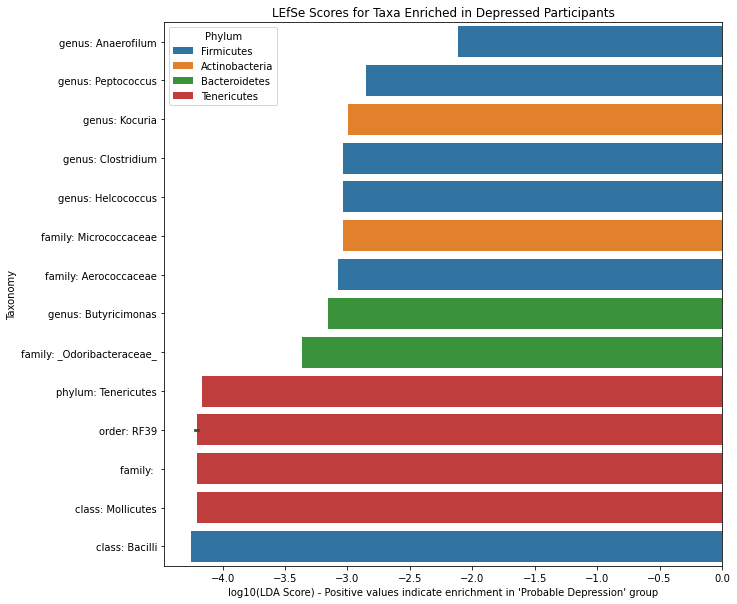

In [80]:
ax = sns.barplot(y="plotnames",
                 x="LDA Score (log10)",
                 hue = "Phylum",
                 data = lefse, 
                 dodge=False,
                 hue_order=["Firmicutes", "Actinobacteria", "Bacteroidetes","Tenericutes", 
                            "Proteobacteria","Verrucomicrobia"])

ax.set_ylabel("Taxonomy")
ax.set_title("LEfSe Scores for Taxa Enriched in Depressed Participants")
ax.set_xlabel("log10(LDA Score) - Positive values indicate enrichment in 'Probable Depression' group")
plt.gcf().set_size_inches(10,10)
plt.savefig("Figures/CESD-LEfSe.pdf")
plt.show()


In [81]:
lefse = lefse[lefse["plotnames"].isna()==False]

In [82]:
cesdlefse = lefse

In [83]:
lefse.to_csv("lefse_cesd_plotdata.csv")

# Chemo Results

In [84]:
lefse = pd.read_csv("lefse_chemo_out.lefse_internal_res", 
                    sep="\t", 
                    header=None)

lefse.rename(mapper={0: "Bacteria",
                     1: "Log10(highest class average)",
                     2: "Highest Class",
                     3: "LDA Score (log10)",
                     4: "p value"},
             axis=1, inplace=True)

In [85]:
#filter only significant results
lefse = lefse.loc[lefse["Highest Class"].isna()==False]

#apply plotnames
lefse.loc[:,"plotnames"] = lefse.loc[:,"Bacteria"].apply(func=lambda x: make_plotnames(x))

In [86]:
lefse.loc[:,'tax_split'] =lefse.loc[:,'Bacteria'].apply(taxonomy_splitter, splitter=".")

lefse.loc[:,'Domain'] = lefse.loc[:,'tax_split'].apply(lambda x: x[0])
lefse.loc[:,'Phylum'] = lefse.loc[:,'tax_split'].apply(lambda x: x[1])
lefse.loc[:,'Class'] = lefse.loc[:,'tax_split'].apply(lambda x: x[2])
lefse.loc[:,'Order'] = lefse.loc[:,'tax_split'].apply(lambda x: x[3])
lefse.loc[:,'Family'] = lefse.loc[:,'tax_split'].apply(lambda x: x[4])
lefse.loc[:,'Genus'] = lefse.loc[:,'tax_split'].apply(lambda x: x[5])
lefse.loc[:,'Species'] = lefse.loc[:,'tax_split'].apply(lambda x: x[6])
lefse.drop('tax_split', axis=1, inplace=True)

lefse.loc[lefse["Highest Class"]=="2 - No","LDA Score (log10)"] = lefse.loc[lefse["Highest Class"]=="2 - No","LDA Score (log10)"].apply(lambda x: -1*x)

lefse.sort_values("LDA Score (log10)", ascending=False, inplace=True)


In [87]:
lefse = lefse.loc[lefse["plotnames"]!="genus: coprostanoligenes_group"]

In [88]:
lefse.loc[(lefse["LDA Score (log10)"] < -2.5) | (lefse["LDA Score (log10)"] > 2)]

,Bacteria,Log10(highest class average),Highest Class,LDA Score (log10),p value,plotnames,Domain,Phylum,Class,Order,Family,Genus,Species
93,k__Bacteria.p__Firmicutes.c__Erysipelotrichi.o...,3.876394,1 - Yes,3.458271,0.0479725808511,genus: Clostridium,Bacteria,Firmicutes,Erysipelotrichi,Erysipelotrichales,Erysipelotrichaceae,Clostridium,NA
177,k__Bacteria.p__Proteobacteria.c__Gammaproteoba...,3.389262,1 - Yes,2.992322,0.016458286127,genus: Actinobacillus,Bacteria,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Actinobacillus,NA
237,k__Bacteria.p__Proteobacteria.c__Gammaproteoba...,3.389262,1 - Yes,2.957898,0.016458286127,family: Pasteurellaceae,Bacteria,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,NA,NA
37,k__Bacteria.p__Proteobacteria.c__Gammaproteoba...,3.389262,1 - Yes,2.895369,0.016458286127,order: Pasteurellales,Bacteria,Proteobacteria,Gammaproteobacteria,Pasteurellales,NA,NA,NA
62,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,2.640080,2 - No,-2.609689,0.0425966370078,genus: Mogibacterium,Bacteria,Firmicutes,Clostridia,Clostridiales,_Mogibacteriaceae_,Mogibacterium,NA
58,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o_...,2.977065,2 - No,-2.674687,0.0425966370078,genus: _Prevotella_,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,_Paraprevotellaceae_,_Prevotella_,NA
332,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,1.835979,2 - No,-2.689618,0.0425966370078,family: EtOH8,Bacteria,Firmicutes,Clostridia,Clostridiales,EtOH8,NA,NA
82,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,1.835979,2 - No,-2.747254,0.0425966370078,order: Clostridiales,Bacteria,Firmicutes,Clostridia,Clostridiales,EtOH8,,NA
324,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,2.825334,2 - No,-2.785950,0.0425966370078,genus: Peptococcus,Bacteria,Firmicutes,Clostridia,Clostridiales,Peptococcaceae,Peptococcus,NA
262,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactob...,3.112433,2 - No,-2.866894,0.0417788036294,genus: Lactococcus,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Lactococcus,NA


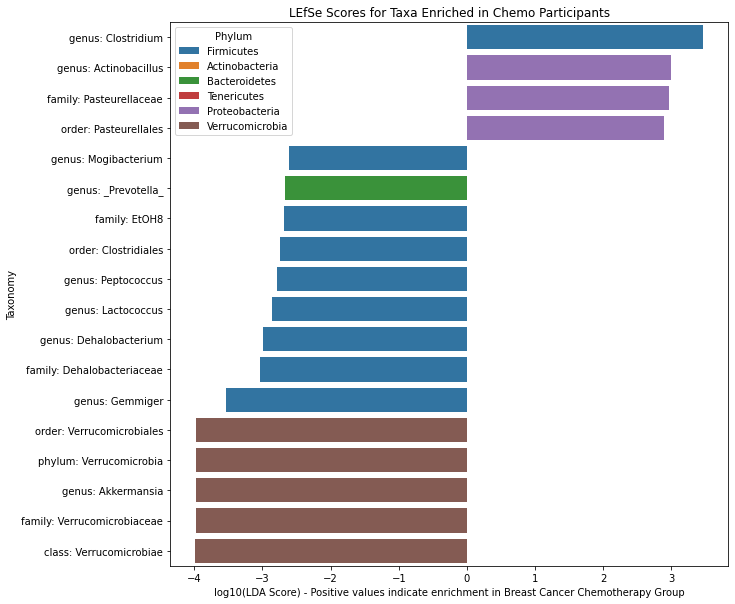

In [89]:
ax = sns.barplot(y="plotnames",
                 x="LDA Score (log10)",
                 hue = "Phylum",
                 data = lefse.loc[(lefse["LDA Score (log10)"] < -2.5) | (lefse["LDA Score (log10)"] > 2)], 
                 dodge=False,
                 hue_order=["Firmicutes", "Actinobacteria", "Bacteroidetes","Tenericutes", 
                            "Proteobacteria","Verrucomicrobia"])

ax.set_ylabel("Taxonomy")
ax.set_title("LEfSe Scores for Taxa Enriched in Chemo Participants")
ax.set_xlabel("log10(LDA Score) - Positive values indicate enrichment in Breast Cancer Chemotherapy Group")
plt.gcf().set_size_inches(10,10)
plt.savefig("Figures/Chemo-LEfSe.pdf")
plt.show()


In [90]:
chemolefse = lefse

In [91]:
lefse.to_csv("lefse_chemo_plotdata.csv")

## Fact-Cog

In [92]:
lefse = pd.read_csv("lefse_fact_out.lefse_internal_res", 
                    sep="\t", 
                    header=None)

lefse.rename(mapper={0: "Bacteria",
                     1: "Log10(highest class average)",
                     2: "Highest Class",
                     3: "LDA Score (log10)",
                     4: "p value"},
             axis=1, inplace=True)

In [93]:
#filter only significant results
lefse = lefse.loc[lefse["Highest Class"].isna()==False]

#apply plotnames
lefse.loc[:,"plotnames"] = lefse.loc[:,"Bacteria"].apply(func=lambda x: make_plotnames(x))

In [94]:
lefse.loc[:,'tax_split'] =lefse.loc[:,'Bacteria'].apply(taxonomy_splitter, splitter=".")

lefse.loc[:,'Domain'] = lefse.loc[:,'tax_split'].apply(lambda x: x[0])
lefse.loc[:,'Phylum'] = lefse.loc[:,'tax_split'].apply(lambda x: x[1])
lefse.loc[:,'Class'] = lefse.loc[:,'tax_split'].apply(lambda x: x[2])
lefse.loc[:,'Order'] = lefse.loc[:,'tax_split'].apply(lambda x: x[3])
lefse.loc[:,'Family'] = lefse.loc[:,'tax_split'].apply(lambda x: x[4])
lefse.loc[:,'Genus'] = lefse.loc[:,'tax_split'].apply(lambda x: x[5])
lefse.loc[:,'Species'] = lefse.loc[:,'tax_split'].apply(lambda x: x[6])
lefse.drop('tax_split', axis=1, inplace=True)

lefse.loc[lefse["Highest Class"]=="low","LDA Score (log10)"] = lefse.loc[lefse["Highest Class"]=="low","LDA Score (log10)"].apply(lambda x: -1*x)

lefse.sort_values("LDA Score (log10)", ascending=False, inplace=True)


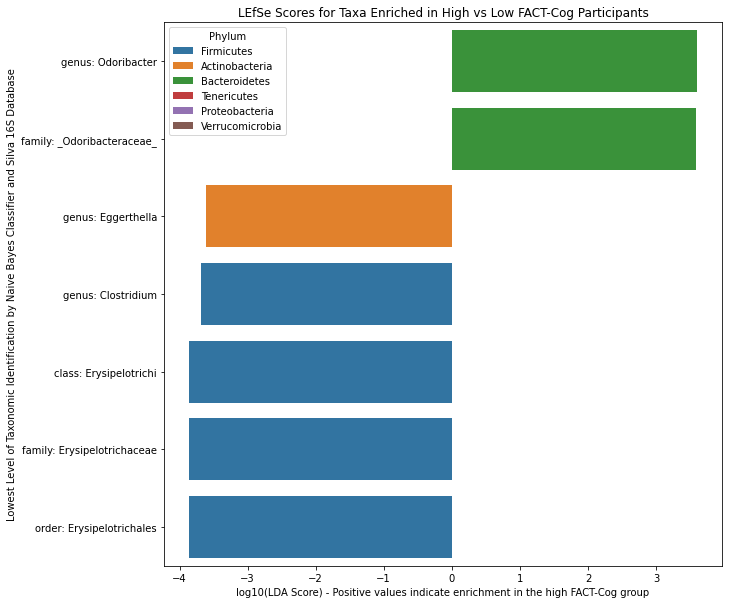

In [95]:
ax = sns.barplot(y="plotnames",
                 x="LDA Score (log10)",
                 hue="Phylum",
                 data=lefse.loc[(lefse["LDA Score (log10)"] < -2) | (lefse["LDA Score (log10)"] > 2)], 
                 dodge=False,
                 hue_order=["Firmicutes", "Actinobacteria", "Bacteroidetes","Tenericutes", 
                            "Proteobacteria","Verrucomicrobia"])

ax.set_ylabel("Lowest Level of Taxonomic Identification by Naive Bayes Classifier and Silva 16S Database")
ax.set_title("LEfSe Scores for Taxa Enriched in High vs Low FACT-Cog Participants")
ax.set_xlabel("log10(LDA Score) - Positive values indicate enrichment in the high FACT-Cog group")
plt.gcf().set_size_inches(10,10)
plt.savefig("Figures/FACT-LEfSe.pdf")
plt.show()

# Finding common microbes

In [104]:
shared = list(set(lefse["Bacteria"]).intersection(set(chemolefse["Bacteria"])))

shared

['k__Bacteria.p__Firmicutes.c__Erysipelotrichi.o__Erysipelotrichales.f__Erysipelotrichaceae.g__Clostridium']

In [105]:
shared = list(set(cesdlefse["Bacteria"]).intersection(set(chemolefse["Bacteria"])))

shared

['k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Peptococcaceae.g__Peptococcus']

In [106]:
shared = set(lefse["Bacteria"]).intersection(set(chemolefse["Bacteria"])).intersection(cesdlefse["Bacteria"])

allshared = lefse.loc[lefse["Bacteria"].apply(lambda x: x in shared)]

allshared

,Bacteria,Log10(highest class average),Highest Class,LDA Score (log10),p value,plotnames,Domain,Phylum,Class,Order,Family,Genus,Species


# ALL THAT FOLLOWS THIS IS FROM BEFORE THE BLOOMS WERE REMOVED

In [241]:
[x for x in allshared["Bacteria"]]

['d__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridia_UCG_014.f__Clostridia_UCG_014.g__Clostridia_UCG_014.__',
 'd__Bacteria.p__Firmicutes.c__Clostridia.o__Oscillospirales.f__Ruminococcaceae.g__Subdoligranulum',
 'd__Bacteria.p__Firmicutes.c__Clostridia.o__Oscillospirales.f__Ruminococcaceae.g__Subdoligranulum.__',
 'd__Bacteria.p__Firmicutes.c__Clostridia.o__Lachnospirales.f__Lachnospiraceae.g__Coprococcus',
 'd__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridia_UCG_014.f__Clostridia_UCG_014.g__Clostridia_UCG_014.s__uncultured_Acetivibrio',
 'd__Bacteria.p__Firmicutes.c__Clostridia.o__Lachnospirales.f__Lachnospiraceae.g__Lachnospiraceae_UCG_010.s__uncultured_organism',
 'd__Bacteria.p__Firmicutes.c__Clostridia.o__Oscillospirales.f__UCG_010.g__UCG_010.s__uncultured_bacterium']

Cool! The bacteria listed above are enriched in the controls, lower depression group, and . . . high fact cog? I thought emily said higher fact cog was associated with more dysfunction? **CORRECTION** high fact cog is better functioning!

In [243]:
alls = lefse[["Bacteria", "plotnames","Highest Class", "LDA Score (log10)"]]

alls.loc[:,"Chemo_cat"] = chemolefse.loc[:,"Highest Class"]
alls.loc[:,"LDA Score (log10) chemo"] = chemolefse.loc[:,"LDA Score (log10)"]

alls.loc[:,"Cesd_cat"] = cesdlefse.loc[:,"Highest Class"]
alls.loc[:,"LDA Score (log10) cesd"] = cesdlefse.loc[:,"LDA Score (log10)"]

alls.loc[:,"LDA Score (log10) fact cog"] = lefse.loc[:,"LDA Score (log10)"].apply(lambda x: x*-1)

alls.set_index("plotnames",inplace=True)

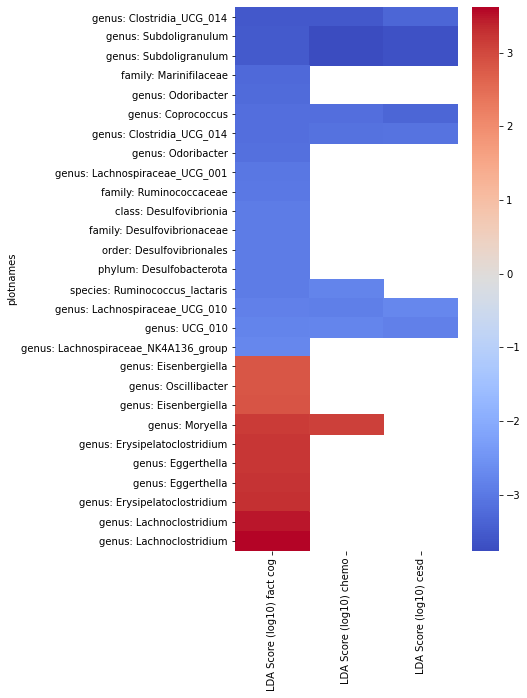

In [244]:
sns.heatmap(alls[["LDA Score (log10) fact cog", "LDA Score (log10) chemo", "LDA Score (log10) cesd"]],
            cmap="coolwarm",
           yticklabels=True)
plt.gcf().set_size_inches(5,10)
plt.show()

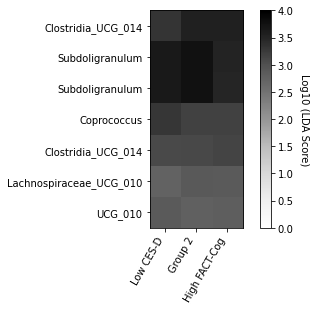

In [111]:
plt.imshow(allshared[["LDA Score (log10) cesd","LDA Score (log10) chemo","LDA Score (log10) fact-cog"]],
          cmap="Greys")
plt.clim(0,4)
plt.yticks(range(allshared.shape[0]), [x.split(" ")[-1] for x in allshared["plotnames"]])
plt.xticks(range(3), ["Low CES-D", "Group 2", "High FACT-Cog"],
          rotation=60, ha="right")
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("Log10 (LDA Score)", rotation=270)
plt.savefig("shared-heatmap-LEfSe.pdf")
plt.show()

In [245]:
pd.concat([lefse[["plotnames", "Highest Class", "LDA Score (log10)"]],
            chemolefse.loc[:,["Highest Class", "LDA Score (log10)"]],
            cesdlefse.loc[:,["Highest Class", "LDA Score (log10)"]]],
         axis=1)

,plotnames,Highest Class,LDA Score (log10),Highest Class,LDA Score (log10),Highest Class,LDA Score (log10)
11,genus: Coprococcus,high,3.178360,2 - No,-3.180847,Possible_Depression,-3.309755
12,NaN,NaN,NaN,NaN,NaN,Possible_Depression,-2.752667
20,NaN,NaN,NaN,2 - No,-3.505035,NaN,NaN
30,NaN,NaN,NaN,2 - No,-2.738275,NaN,NaN
31,NaN,NaN,NaN,1 - Yes,2.974844,NaN,NaN
...,...,...,...,...,...,...,...
1118,genus: Eggerthella,low,-3.238075,NaN,NaN,NaN,NaN
1128,class: Desulfovibrionia,high,2.941570,NaN,NaN,NaN,NaN
1144,genus: Odoribacter,high,3.148965,NaN,NaN,NaN,NaN
1145,NaN,NaN,NaN,2 - No,-3.799481,Possible_Depression,-3.694472


## Getting relative abundances

In [246]:
allshared.loc[:,"Bacteria"] = allshared.loc[:,"Bacteria"].apply(lambda x: "|".join(x.split(".")))

In [247]:
def fixtax(string):
    while sum("|"==c for c in string) < 6:
        string+="|__"
    return string

allshared.loc[:,"AltBacteria"] = allshared.loc[:,"Bacteria"].apply(fixtax)


[x for x in allshared["AltBacteria"]]

['d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG_014|f__Clostridia_UCG_014|g__Clostridia_UCG_014|__',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|__',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG_014|f__Clostridia_UCG_014|g__Clostridia_UCG_014|s__uncultured_Acetivibrio',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG_010|s__uncultured_organism',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG_010|g__UCG_010|s__uncultured_bacterium']

In [248]:
tax_df.loc[:,allshared["AltBacteria"]]

/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG_014|f__Clostridia_UCG_014|g__Clostridia_UCG_014|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG_014|f__Clostridia_UCG_014|g__Clostridia_UCG_014|s__uncultured_Acetivibrio,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG_010|s__uncultured_organism,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG_010|g__UCG_010|s__uncultured_bacterium
1.0,NaN,0.024765,0.024765,0.000000,NaN,NaN,NaN
10.0,NaN,0.012088,0.012088,0.000000,NaN,NaN,NaN
12.0,NaN,0.007611,0.007611,0.000000,NaN,NaN,NaN
14.0,NaN,0.029268,0.029268,0.004873,NaN,NaN,NaN
15.0,NaN,0.015240,0.015240,0.004678,NaN,NaN,NaN
17.0,NaN,0.005910,0.005910,0.002932,NaN,NaN,NaN
19.0,NaN,0.036881,0.036881,0.007126,NaN,NaN,NaN
21.0,NaN,0.000000,0.000000,0.002542,NaN,NaN,NaN
22.0,NaN,0.002001,0.002001,0.000000,NaN,NaN,NaN
23.0,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN


I'm not quite sure what LEfSe is doing, but there are some LEfSe output bacteria that aren't present in our input data. I guess it groups by taxonomic level.

In [249]:
[x for x in allshared["Bacteria"]]

['d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG_014|f__Clostridia_UCG_014|g__Clostridia_UCG_014|__',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG_014|f__Clostridia_UCG_014|g__Clostridia_UCG_014|s__uncultured_Acetivibrio',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG_010|s__uncultured_organism',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG_010|g__UCG_010|s__uncultured_bacterium']

In [250]:
for col in tax_df.columns:
    for tax in allshared["Bacteria"]:
        if col.startswith(tax):
            print(col)

d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|__
d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_eutactus
d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|s__Lachnospiraceae_bacterium
d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|s__metagenome
d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__
d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__
d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|s__uncultured_Ruminococcaceae


**Looks like LEfSe replaces dashes with undercores, which is why the UCG weren't showing up**

In [255]:
allshared.loc[:,"AltBacteria"] = allshared.loc[:,"AltBacteria"].apply(lambda x: "UCG-".join(x.split("UCG_")))

Dropping #259, which is a repeat subdoligranulum in order to not have it show up in the relative abundances

In [291]:
allshared.drop(259)

,Bacteria,Log10(highest class average),Highest Class,LDA Score (log10),p value,plotnames,Domain,Phylum,Class,Order,Family,Genus,Species,Chemo_cat,LDA Score (log10) chemo,Chemo_cesd,LDA Score (log10) cesd,LDA Score (log10) fact-cog,AltBacteria
53,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,3.778722,high,3.549433,0.0141849434845,genus: Clostridia_UCG_014,Bacteria,Firmicutes,Clostridia,Clostridia_UCG_014,Clostridia_UCG_014,Clostridia_UCG_014,,2 - No,3.548925,Possible_Depression,3.316972,3.549433,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...
671,d__Bacteria|p__Firmicutes|c__Clostridia|o__Osc...,4.199176,high,3.499730,0.0251357643071,genus: Subdoligranulum,Bacteria,Firmicutes,Clostridia,Oscillospirales,Ruminococcaceae,Subdoligranulum,,2 - No,3.756117,Possible_Depression,3.648870,3.499730,d__Bacteria|p__Firmicutes|c__Clostridia|o__Osc...
11,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lac...,3.769446,high,3.178360,0.0186346707912,genus: Coprococcus,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Coprococcus,NA,2 - No,3.180847,Possible_Depression,3.309755,3.178360,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lac...
250,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,3.307702,high,3.155453,0.00912455670065,genus: Clostridia_UCG_014,Bacteria,Firmicutes,Clostridia,Clostridia_UCG_014,Clostridia_UCG_014,Clostridia_UCG_014,uncultured_Acetivibrio,2 - No,3.102056,Possible_Depression,3.083465,3.155453,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...
45,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lac...,2.586020,high,2.863071,0.0217081946356,genus: Lachnospiraceae_UCG_010,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lachnospiraceae_UCG_010,uncultured_organism,2 - No,2.881420,Possible_Depression,2.738264,2.863071,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lac...
850,d__Bacteria|p__Firmicutes|c__Clostridia|o__Osc...,2.983600,high,2.806075,0.00818573249914,genus: UCG_010,Bacteria,Firmicutes,Clostridia,Oscillospirales,UCG_010,UCG_010,uncultured_bacterium,2 - No,2.771279,Possible_Depression,2.863329,2.806075,d__Bacteria|p__Firmicutes|c__Clostridia|o__Osc...


In [292]:
sharedtax = tax_df.loc[:,allshared.drop(259)["AltBacteria"]]

/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. The left and right margins cannot be made large en

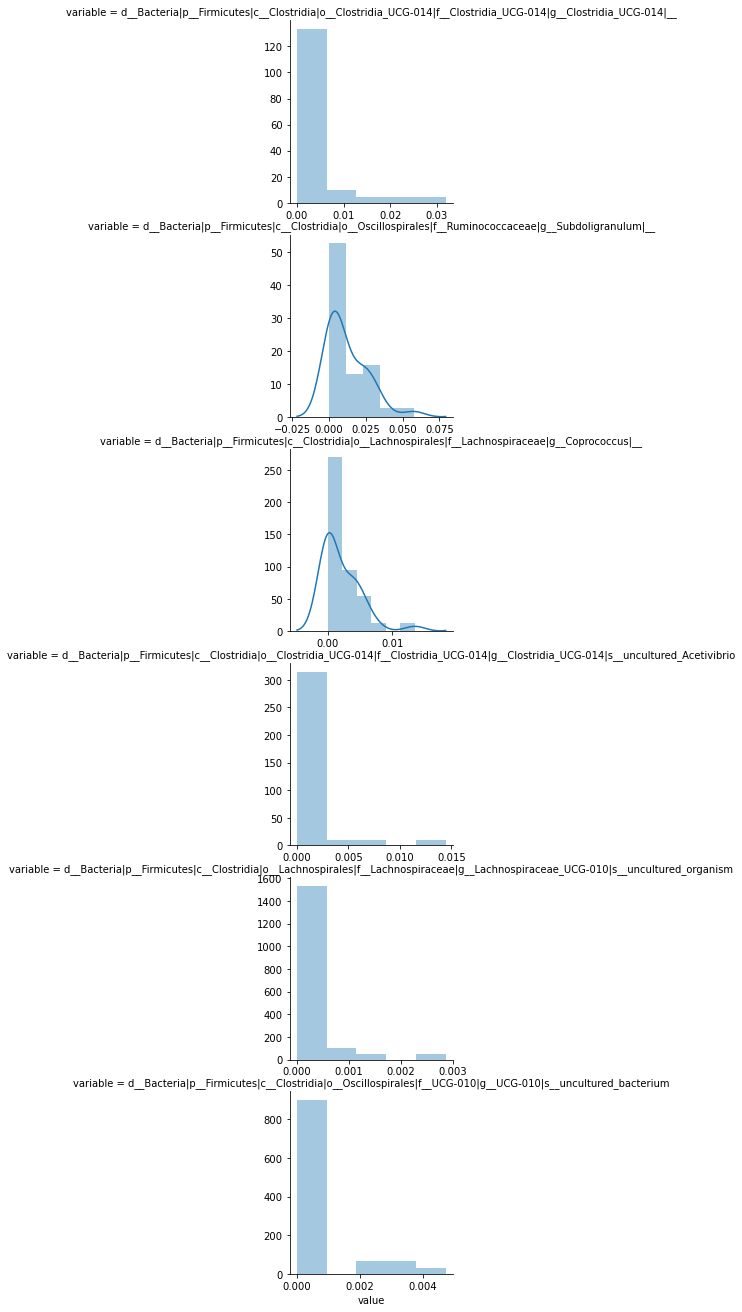

In [294]:
g = sns.FacetGrid(data=pd.melt(sharedtax),
                 row="variable",
                 sharex=False, sharey=False)
g.map(sns.distplot, "value")

In [259]:
sharedtax.head()

,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|s__uncultured_Acetivibrio,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG-010|s__uncultured_organism,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG-010|g__UCG-010|s__uncultured_bacterium
1.0,0.000000,0.024765,0.024765,0.000000,0.000000,0.000000,0.000000
10.0,0.009364,0.012088,0.012088,0.000000,0.000000,0.002867,0.000263
12.0,0.000000,0.007611,0.007611,0.000000,0.000000,0.000000,0.000000
14.0,0.000000,0.029268,0.029268,0.004873,0.000000,0.000000,0.002657
15.0,0.007849,0.015240,0.015240,0.004678,0.002817,0.000668,0.002844


In [297]:
for col in sharedtax.columns:
    print(col, "\n", stats.shapiro(sharedtax[col]))
    if stats.shapiro(sharedtax[col])[1] < 0.05:
        print("NOT NORMAL")

d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|__ 
 (0.47539079189300537, 9.788240218355782e-10)
NOT NORMAL
d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__ 
 (0.8345869183540344, 0.00015873092343099415)
NOT NORMAL
d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|__ 
 (0.7228899598121643, 1.4784276345380931e-06)
NOT NORMAL
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|s__uncultured_Acetivibrio 
 (0.3660242557525635, 8.020482888948521e-11)
NOT NORMAL
d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG-010|s__uncultured_organism 
 (0.35966283082962036, 6.999809065710849e-11)
NOT NORMAL
d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG-010|g__UCG-010|s__uncultured_bacterium 
 (0.5037287473678589, 1.980878350238413e-0

In [298]:
for col in sharedtax.columns:
    print("\n", col, "\n", stats.shapiro(sharedtax[col].apply(lambda x: np.arcsin(np.sqrt(x)))))
    if stats.shapiro(sharedtax[col])[1] < 0.05:
        print("NOT NORMAL")
    else:
        print("YES NORMAL")


 d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|__ 
 (0.5384275913238525, 4.87499640655642e-09)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__ 
 (0.9291077256202698, 0.033006805926561356)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|__ 
 (0.7705438733100891, 9.289971785619855e-06)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|s__uncultured_Acetivibrio 
 (0.4300062656402588, 3.332186748750132e-10)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG-010|s__uncultured_organism 
 (0.40219807624816895, 1.771552349261185e-10)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG-010|g__UCG-010|s__uncultured_bacterium 
 (0.5495753288269043, 6.57242749113

In [304]:
for col in sharedtax.columns:
    print("\n", col, "\n", stats.shapiro(composition.clr(sharedtax[col].apply(lambda x: x+0.001))))
    if stats.shapiro(sharedtax[col])[1] < 0.05:
        print("NOT NORMAL")
    else:
        print("YES NORMAL")


 d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|__ 
 (0.540542483329773, 5.157415827738987e-09)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__ 
 (0.8929839730262756, 0.0035207041073590517)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|__ 
 (0.7638115882873535, 7.077144800859969e-06)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|s__uncultured_Acetivibrio 
 (0.42386966943740845, 2.893411621407438e-10)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG-010|s__uncultured_organism 
 (0.39432191848754883, 1.486720885290893e-10)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG-010|g__UCG-010|s__uncultured_bacterium 
 (0.5243210792541504, 3.362811140

In [312]:
clr_sharedtax = pd.DataFrame(composition.clr(sharedtax.apply(lambda x: x+0.001)),
                            columns=sharedtax.columns,
                            index=sharedtax.index)

/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


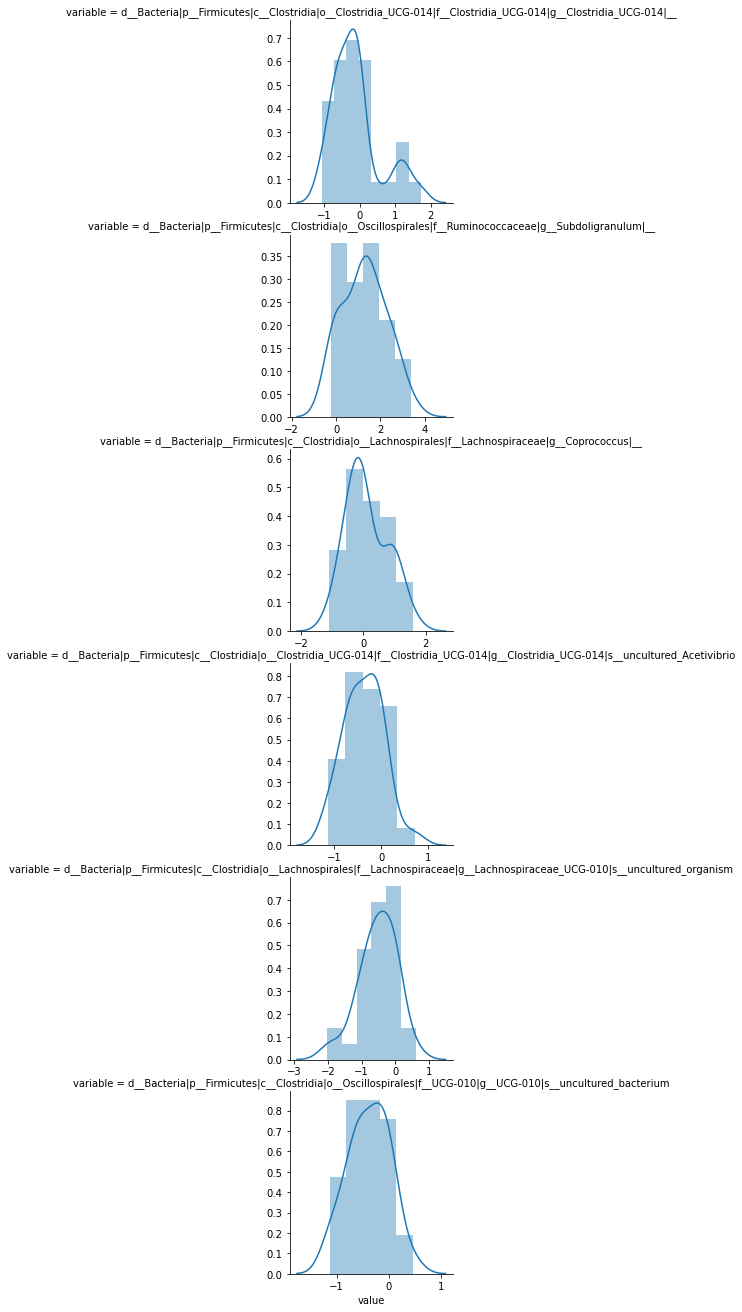

In [314]:
g = sns.FacetGrid(data=pd.melt(clr_sharedtax),
                 row="variable",
                 sharex=False, sharey=False)
g.map(sns.distplot, "value")
plt.show()

These may not pass shapiro-wilks, but they do look relatively normal based on the histograms! Much better than before.

In [316]:
clr_sharedtax.to_csv("clr_transformed_sharedtaxa.csv")

In [317]:
mapping

,barcodesequence,linkerprimersequence,study,plate.sample.id,plate.well.id,primer.plate,primer.well.id,body-site,date_collected,time_collected,...,fact_c_ab_8-cat,fact_c_ab_9-cat,fact_c_qol_1-cat,fact_c_qol_2-cat,fact_c_qol_3-cat,fact_c_qol_4-cat,Zpromis_Tscore_TOTAL,Zstress_scale_TOTAL,Zcesd_TOTAL,Zdistress_total
sampleid,,,,,,,,,,,,,,,,,,,,,
1.0,TAGACCGACTCC,AA,CU Denver BC Microbiome,1001-S1,A1,7.0,A1,gut,10/2/18,Not listed,...,Quite a bit,Quite a bit,A little bit,Not at all,Not at all,Not at all,1.47103,-0.01736,0.73560,2.19
3.0,TCCGACCCGATC,AA,CU Denver BC Microbiome,1005,C1,7.0,C1,gut,5/4/19,7:20 AM,...,Quite a bit,Quite a bit,Not at all,Not at all,Not at all,Not at all,0.49597,0.79283,0.36780,1.66
4.0,TCACTGCTAGGA,AA,CU Denver BC Microbiome,1006-S1,D1,7.0,D1,gut,2/23/18,6:35 AM,...,Very much,Very much,Not at all,Not at all,Not at all,Not at all,-0.65763,-0.62501,-1.22601,-2.51
6.0,AGCTATGTATGG,AA,CU Denver BC Microbiome,1007 - S1,F1,7.0,F1,gut,11/14/18,Not listed,...,Very much,Very much,Not at all,Not at all,Not at all,Not at all,0.27623,1.19793,1.96161,3.44
8.0,AAGGGTTAGTCT,AA,CU Denver BC Microbiome,1008-S1,H1,7.0,H1,gut,4/13/18,Not listed,...,Very much,Very much,A little bit,Not at all,Not at all,Not at all,-0.32803,-0.42246,0.00000,-0.75
10.0,TTCCCACCCATT,AA,CU Denver BC Microbiome,1009 - S1,B2,7.0,B2,gut,2/10/19,Not listed,...,Very much,Very much,Not at all,Not at all,Not at all,Not at all,-0.10830,-1.23265,-0.98081,-2.32
12.0,GGTCCTTCCCGA,AA,CU Denver BC Microbiome,1010-S1,D2,7.0,D2,gut,12/14/18,Not listed,...,Quite a bit,Somewhat,Somewhat,Somewhat,A little bit,A little bit,0.27623,-0.42246,-0.85821,-1.00
14.0,TTCCGAATCGGC,AA,CU Denver BC Microbiome,1011,F2,7.0,F2,gut,7/9/19,11:00 AM,...,Somewhat,Somewhat,Quite a bit,A little bit,A little bit,A little bit,-0.16323,-0.42246,-1.22601,-1.81
15.0,GCATGTCGAAAT,AA,CU Denver BC Microbiome,1012-S1,G2,7.0,G2,gut,1/1/19,Not listed,...,Very much,Very much,Not at all,Not at all,Not at all,Not at all,-0.46536,0.38774,-0.36780,-0.45


In [318]:
clr_sharedtax

,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|s__uncultured_Acetivibrio,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG-010|s__uncultured_organism,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG-010|g__UCG-010|s__uncultured_bacterium
1.0,-5.415050e-01,2.707525e+00,-5.415050e-01,-5.415050e-01,-5.415050e-01,-5.415050e-01
10.0,1.255748e+00,1.489045e+00,-1.082622e+00,-1.082622e+00,2.697615e-01,-8.493106e-01
12.0,-3.588361e-01,1.794180e+00,-3.588361e-01,-3.588361e-01,-3.588361e-01,-3.588361e-01
14.0,-1.079490e+00,2.330587e+00,6.908530e-01,-1.079490e+00,-1.079490e+00,2.170295e-01
15.0,5.299685e-01,1.137104e+00,8.625337e-02,-3.108075e-01,-1.138553e+00,-3.039656e-01
17.0,-7.529727e-01,1.179957e+00,6.160728e-01,-7.529727e-01,-7.529727e-01,4.628882e-01
19.0,-4.119888e-02,2.496783e+00,9.573956e-01,-1.137660e+00,-1.137660e+00,-1.137660e+00
21.0,-2.108002e-01,-2.108002e-01,1.054001e+00,-2.108002e-01,-2.108002e-01,-2.108002e-01
22.0,-1.831430e-01,9.157150e-01,-1.831430e-01,-1.831430e-01,-1.831430e-01,-1.831430e-01
23.0,-2.220446e-16,-2.220446e-16,-2.220446e-16,-2.220446e-16,-2.220446e-16,-2.220446e-16


In [321]:
clr_sharedtax["plate.sample.id"]= mapping["plate.sample.id"]
clr_sharedtax["hcvsbc-cat"]= mapping["hcvsbc-cat"]

In [322]:
clr_sharedtax

,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|s__uncultured_Acetivibrio,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG-010|s__uncultured_organism,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG-010|g__UCG-010|s__uncultured_bacterium,plate.sample.id,hcvsbc-cat
1.0,-5.415050e-01,2.707525e+00,-5.415050e-01,-5.415050e-01,-5.415050e-01,-5.415050e-01,1001-S1,1 - Yes
10.0,1.255748e+00,1.489045e+00,-1.082622e+00,-1.082622e+00,2.697615e-01,-8.493106e-01,1009 - S1,2 - No
12.0,-3.588361e-01,1.794180e+00,-3.588361e-01,-3.588361e-01,-3.588361e-01,-3.588361e-01,1010-S1,2 - No
14.0,-1.079490e+00,2.330587e+00,6.908530e-01,-1.079490e+00,-1.079490e+00,2.170295e-01,1011,1 - Yes
15.0,5.299685e-01,1.137104e+00,8.625337e-02,-3.108075e-01,-1.138553e+00,-3.039656e-01,1012-S1,2 - No
17.0,-7.529727e-01,1.179957e+00,6.160728e-01,-7.529727e-01,-7.529727e-01,4.628882e-01,1013 - S1,1 - Yes
19.0,-4.119888e-02,2.496783e+00,9.573956e-01,-1.137660e+00,-1.137660e+00,-1.137660e+00,1015-S1,2 - No
21.0,-2.108002e-01,-2.108002e-01,1.054001e+00,-2.108002e-01,-2.108002e-01,-2.108002e-01,1017,1 - Yes
22.0,-1.831430e-01,9.157150e-01,-1.831430e-01,-1.831430e-01,-1.831430e-01,-1.831430e-01,1018,1 - Yes
23.0,-2.220446e-16,-2.220446e-16,-2.220446e-16,-2.220446e-16,-2.220446e-16,-2.220446e-16,1020,1 - Yes


In [323]:
clr_sharedtax.to_csv("clr_transformed_sharedtaxa_2.csv")